<a href="https://colab.research.google.com/github/ISE-CS4445-AI/challenge-6-TiernanScullyISE/blob/main/challenge-6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Challenge #6: Reducing Overfitting with Regularization (FashionMNIST)

**Instructions**:
- This challenge builds on **Week 6**’s regularization lessons: **data augmentation**, **dropout**, and **weight decay**.
- We demonstrate a baseline CNN on **FashionMNIST** that clearly overfits. Then we apply these techniques to see the improvement.

**Scoring**:  9 points total. Fill in the `# TODO` placeholders and fill in the final reflection markdown cell. **There is no autograder** for this assignment. If your code works without errors and achieves the objectives of reducing overfitting by the end of this challenge, you will have done well. 👍

We’ll use the **FashionMNIST** dataset, which consists of 60,000 training images and 10,000 test images of 28x28 grayscale images of 10 different fashion categories. By applying these techniques, we aim to reduce overfitting and improve robust performance.

---

## Imports & Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

print("Torch version:", torch.__version__)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

Torch version: 2.5.1+cu124
Using device: cuda


### Utility functions

Defining the utility function to plot metrics below.

In [2]:
'''
Description:
Utility function to plot line plots in a single graph

Params:
dataDict: List - A list of tuples containing the data to be plotted and corresponding plot params as a dictionary (optional).
           Expected key names in paramDict:
           -> label: str - String label to be given to the plot.
                           Only necessary if the 'legend' function param is set to True (False by default).
           -> ha: str - Specifies the horizontal alignment ('left', 'right' or 'center') of text above each point in the plot.
           -> fontsize: int - Sets the font size of text displayed above each point in the plot.
           -> marker: str - Sets the style of marker to be displayed for each data point on the plot. Set to 'o' by default.
           -> decimalPlaces: int - Sets the number of decimal places to display for each data point.
           -> displayPercent: bool - Boolean to decide whether to display numbers in percentage format.
           -> displayOffset: float - positive or negative float value that determines the display offset of text above data point.
title: str - [optional] Title to be set for the graph.
xlabel: str - [optional] Label for the x-axis to be set for the graph.
ylabel: str - [optional] Label for the y-axis to be set for the graph.
figSize: Tuple - [optional] Sets a custom figure size for the plot based on the width and height values passed as a tuple pair.
legend: bool - [optional] Boolean to decide whether to show the legend or not. Set to False by default
'''
def plotMetrics(dataList, X, title='', xlabel='', ylabel='', figSize=None, legend=False):
    if figSize:
            plt.figure(figsize=(figSize))
    for data in dataList:
        y, paramDict = data
        # Getting plot params
        label = paramDict['label'] if 'label' in paramDict else ''
        marker = paramDict['marker'] if 'marker' in paramDict else 'o'
        ha = paramDict['ha'] if 'ha' in paramDict else 'center'
        fontSize = paramDict['fontSize'] if 'fontSize' in paramDict else 8
        decimalPlaces = paramDict['decimalPlaces'] if 'decimalPlaces' in paramDict else 2
        displayPercent = paramDict['displayPercent'] if 'displayPercent' in paramDict else False
        displayOffset = paramDict['displayOffset'] if 'displayOffset' in paramDict else 0.005

        plt.plot(X, y, label=label, marker=marker)

        # Getting the data values to show on the plotted points along the line
        for i, v in enumerate(y):
            percentMultiplier = 100 if displayPercent else 1
            v_str = f'{v * percentMultiplier:.{decimalPlaces}f}{"%" if displayPercent else ""}'
            plt.text(i + 1, v + displayOffset, v_str, ha=ha, fontsize=fontSize)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if legend:
        plt.legend()
    plt.show()

## Task 1: getTransforms(augmentation=False) <font color='green'>(1 point)</font>

**Goal**: Return a **train_transform** and a **test_transform**.  
- If `augmentation=True`, apply random transformations. Otherwise just basic.  
- *FashionMNIST* is 28×28 grayscale, so consider **random horizontal flip** or **random rotation**. Keep it simple.

In [7]:
def getTransforms(augmentation=False):
    # Mean and standard deviation for FashionMNIST (approximate)
    mean = (0.2860,)
    std = (0.3530,)

    # Define the transformation for the test set (without any data augmentation)
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    if augmentation:
        # Define the transformation for the train set (with data augmentation)
        train_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),   # Randomly flip the image horizontally
            transforms.RandomRotation(10),         # Randomly rotate the image by up to 10 degrees
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
        return train_transform, test_transform

    # If no augmentation, use the same transformation for both train and test sets
    return test_transform, test_transform


## Task 2: create the dataloaders <font color='green'>(1 point)</font>

In [9]:
def getTransforms(augmentation=False):
    # Mean and standard deviation for FashionMNIST (approximate)
    mean = (0.2860,)
    std = (0.3530,)

    # Define the transformation for the test set (without any data augmentation)
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)  # normalise the image data
    ])

    if augmentation:
        # Define the transformation for the train set (with data augmentation)
        train_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),  # random horizontal flip for augmentation
            transforms.RandomRotation(10),        # random rotation up to 10 degrees
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
        return train_transform, test_transform

    # If no augmentation is applied, use the same transform for both sets
    return test_transform, test_transform

def load_fashionMNIST_data(batch_size=64, augmentation=False):
    """
    Downloads the FashionMNIST dataset and returns train and test data loaders.
    """
    # Obtain the appropriate transformations for training and testing
    train_transform, test_transform = getTransforms(augmentation)

    # Download the FashionMNIST dataset for training and testing
    train_dataset = torchvision.datasets.FashionMNIST(
        root='./data',
        train=True,
        download=True,
        transform=train_transform
    )
    test_dataset  = torchvision.datasets.FashionMNIST(
        root='./data',
        train=False,
        download=True,
        transform=test_transform
    )

    # Create the data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

# Example usage:
train_loader, test_loader = load_fashionMNIST_data(batch_size=64)
print("Train set size:", len(train_loader.dataset))
print("Test set size:", len(test_loader.dataset))


Train set size: 60000
Test set size: 10000


## Task 3: Define a CNN with Dropout  <font color='green'>(2 points)</font>

**Task**:  
- Build a small **CNN** with a few convolution layers, each followed by ReLU & maxpool.  
- Insert **dropout** layers (e.g., `nn.Dropout(0.3)`) to help reduce overfitting.  
- The final linear outputs 10 classes.  
- We'll call it `NetFashion`.

In [10]:
class NetFashion(nn.Module):
    def __init__(self, dropout_prob=0.3, useRegularization=False):
        super().__init__()
        self.useRegularization = useRegularization

        # First convolutional block: input 1 channel -> 32 channels
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        # Second convolutional block: 32 channels -> 64 channels
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        # Max pooling layer (kernel size and stride of 2 halves the spatial dimensions)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Optional dropout regularisation
        if self.useRegularization:
            self.dropout = nn.Dropout(dropout_prob)

        # Third convolutional block: 64 channels -> 128 channels
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        # Fourth convolutional block: 128 channels -> 128 channels
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

        # After two pooling operations, the 28x28 image becomes 7x7.
        # The number of channels from conv4 is 128, so the flattened feature size is 128*7*7 = 6272.
        self.fc1 = nn.Linear(in_features=128 * 7 * 7, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):
        # Convolutional layers with ReLU activation
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # Reduces spatial dimensions

        # Apply dropout after pooling if regularisation is enabled
        if self.useRegularization:
            x = self.dropout(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)  # Further reduction: from 14x14 to 7x7

        # Flatten the feature maps into a vector
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        if self.useRegularization:
            x = self.dropout(x)
        out = self.fc2(x)
        return out

# Example usage:
if __name__ == "__main__":
    # Create a random tensor with batch size 8 and a single channel 28x28 (FashionMNIST image dimensions)
    sample_input = torch.randn(8, 1, 28, 28)

    # Instantiate the model with regularisation enabled
    model = NetFashion(dropout_prob=0.3, useRegularization=True)
    output = model(sample_input)

    print("Output shape:", output.shape)  # Expected shape: (8, 10)


Output shape: torch.Size([8, 10])


## Training Loop

Below is a standard training loop with helper train and test methods defined which should look familiar by now. :)

In [11]:
def train(dataloader, model, loss_fn, optimiser):
    size = len(dataloader.dataset)
    model.train()

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        optimiser.zero_grad()

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # This is the backprop set up. Explain what each of the steps do
        loss.backward()
        optimiser.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    loss, accuracy = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss += loss_fn(pred, y).item()
            accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
    loss /= num_batches
    accuracy /= size

    return loss, accuracy

def train_loop(train_dataloader, test_dataloader, model, loss_fn, optimiser, epochs):
    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []

    # Iterate over each epoch
    for t in tqdm(range(epochs), desc="Epochs"):
        print(f"Epoch {t+1}:\n")
        train(train_dataloader, model, loss_fn, optimiser)

        # Get the overall loss and accuracy for both train and test datasets
        tr_loss, tr_acc = test(train_dataloader, model, loss_fn)
        ts_loss, ts_acc = test(test_dataloader, model, loss_fn)

        print(f"Train Error: \n Accuracy: {(100*tr_acc):>0.1f}%, Avg loss: {tr_loss:>8f} \n")
        print(f"Test Error: \n Accuracy: {(100*ts_acc):>0.1f}%, Avg loss: {ts_loss:>8f} \n")

        # Store and return the losses and accuracies. We can graph these later
        train_loss = train_loss + [tr_loss]
        train_accuracy = train_accuracy + [tr_acc]
        test_loss = test_loss + [ts_loss]
        test_accuracy = test_accuracy + [ts_acc]

    print("Done training!")
    return train_loss, train_accuracy, test_loss, test_accuracy

## Task 4: Evaluate & Check Test Accuracy

**Task**:  
1. Measure train and test metrics for non-regularised model with non-augmented data.  
2. Do the same train and test loop for your regularised model on augmented data with weight decay in the optimiser and observe the difference.
   1. However, apply all the different techniques individually.
   2. Run the code cells to plot metrics after each experiment

### Task 4.1: Non-regularised model with non-augmented data  <font color='green'>(1 point)</font>

In [12]:
model = NetFashion().to(device) # Getting the Fashion MNIST model

# TODO: Define the loss function and the optimiser
loss_fn = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters(), lr=0.001)

In [13]:
epochs = 10
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model, loss_fn, optimiser, epochs)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:

loss: 2.310974  [   64/60000]
loss: 0.555290  [ 6464/60000]
loss: 0.433218  [12864/60000]
loss: 0.610757  [19264/60000]
loss: 0.214483  [25664/60000]
loss: 0.475593  [32064/60000]
loss: 0.198255  [38464/60000]
loss: 0.363374  [44864/60000]
loss: 0.231290  [51264/60000]
loss: 0.200175  [57664/60000]


Epochs:  10%|█         | 1/10 [00:31<04:42, 31.44s/it]

Train Error: 
 Accuracy: 90.4%, Avg loss: 0.267736 

Test Error: 
 Accuracy: 89.5%, Avg loss: 0.301479 

Epoch 2:

loss: 0.367614  [   64/60000]
loss: 0.310336  [ 6464/60000]
loss: 0.381992  [12864/60000]
loss: 0.419924  [19264/60000]
loss: 0.308194  [25664/60000]
loss: 0.209041  [32064/60000]
loss: 0.267713  [38464/60000]
loss: 0.216057  [44864/60000]
loss: 0.183032  [51264/60000]
loss: 0.270730  [57664/60000]


Epochs:  20%|██        | 2/10 [01:02<04:09, 31.18s/it]

Train Error: 
 Accuracy: 93.2%, Avg loss: 0.186414 

Test Error: 
 Accuracy: 91.1%, Avg loss: 0.248061 

Epoch 3:

loss: 0.181613  [   64/60000]
loss: 0.175738  [ 6464/60000]
loss: 0.149273  [12864/60000]
loss: 0.257112  [19264/60000]
loss: 0.168193  [25664/60000]
loss: 0.119279  [32064/60000]
loss: 0.146972  [38464/60000]
loss: 0.098912  [44864/60000]
loss: 0.157290  [51264/60000]
loss: 0.125092  [57664/60000]


Epochs:  30%|███       | 3/10 [01:32<03:35, 30.77s/it]

Train Error: 
 Accuracy: 94.5%, Avg loss: 0.148646 

Test Error: 
 Accuracy: 92.2%, Avg loss: 0.220604 

Epoch 4:

loss: 0.086103  [   64/60000]
loss: 0.165496  [ 6464/60000]
loss: 0.114847  [12864/60000]
loss: 0.133319  [19264/60000]
loss: 0.075775  [25664/60000]
loss: 0.309861  [32064/60000]
loss: 0.058436  [38464/60000]
loss: 0.186471  [44864/60000]
loss: 0.350879  [51264/60000]
loss: 0.111872  [57664/60000]


Epochs:  40%|████      | 4/10 [02:02<03:03, 30.55s/it]

Train Error: 
 Accuracy: 95.7%, Avg loss: 0.130590 

Test Error: 
 Accuracy: 92.4%, Avg loss: 0.209199 

Epoch 5:

loss: 0.137416  [   64/60000]
loss: 0.048151  [ 6464/60000]
loss: 0.144162  [12864/60000]
loss: 0.302678  [19264/60000]
loss: 0.131224  [25664/60000]
loss: 0.115189  [32064/60000]
loss: 0.308276  [38464/60000]
loss: 0.145315  [44864/60000]
loss: 0.180332  [51264/60000]
loss: 0.142917  [57664/60000]


Epochs:  50%|█████     | 5/10 [02:33<02:32, 30.46s/it]

Train Error: 
 Accuracy: 96.4%, Avg loss: 0.097709 

Test Error: 
 Accuracy: 92.0%, Avg loss: 0.221618 

Epoch 6:

loss: 0.056829  [   64/60000]
loss: 0.157884  [ 6464/60000]
loss: 0.096107  [12864/60000]
loss: 0.203060  [19264/60000]
loss: 0.075528  [25664/60000]
loss: 0.062622  [32064/60000]
loss: 0.104249  [38464/60000]
loss: 0.207233  [44864/60000]
loss: 0.141772  [51264/60000]
loss: 0.102562  [57664/60000]


Epochs:  60%|██████    | 6/10 [03:03<02:01, 30.25s/it]

Train Error: 
 Accuracy: 97.3%, Avg loss: 0.074084 

Test Error: 
 Accuracy: 92.6%, Avg loss: 0.241780 

Epoch 7:

loss: 0.009016  [   64/60000]
loss: 0.068115  [ 6464/60000]
loss: 0.070394  [12864/60000]
loss: 0.097588  [19264/60000]
loss: 0.062701  [25664/60000]
loss: 0.117196  [32064/60000]
loss: 0.040978  [38464/60000]
loss: 0.074779  [44864/60000]
loss: 0.078557  [51264/60000]
loss: 0.124711  [57664/60000]


Epochs:  70%|███████   | 7/10 [03:33<01:30, 30.26s/it]

Train Error: 
 Accuracy: 98.0%, Avg loss: 0.058105 

Test Error: 
 Accuracy: 92.5%, Avg loss: 0.244087 

Epoch 8:

loss: 0.052234  [   64/60000]
loss: 0.087734  [ 6464/60000]
loss: 0.011907  [12864/60000]
loss: 0.116215  [19264/60000]
loss: 0.070919  [25664/60000]
loss: 0.124979  [32064/60000]
loss: 0.031313  [38464/60000]
loss: 0.060664  [44864/60000]
loss: 0.002486  [51264/60000]
loss: 0.066027  [57664/60000]


Epochs:  80%|████████  | 8/10 [04:03<01:00, 30.09s/it]

Train Error: 
 Accuracy: 98.1%, Avg loss: 0.052184 

Test Error: 
 Accuracy: 92.1%, Avg loss: 0.303582 

Epoch 9:

loss: 0.049363  [   64/60000]
loss: 0.002404  [ 6464/60000]
loss: 0.090321  [12864/60000]
loss: 0.016131  [19264/60000]
loss: 0.120224  [25664/60000]
loss: 0.086447  [32064/60000]
loss: 0.012562  [38464/60000]
loss: 0.008143  [44864/60000]
loss: 0.068332  [51264/60000]
loss: 0.053471  [57664/60000]


Epochs:  90%|█████████ | 9/10 [04:33<00:30, 30.22s/it]

Train Error: 
 Accuracy: 98.1%, Avg loss: 0.051146 

Test Error: 
 Accuracy: 92.1%, Avg loss: 0.360292 

Epoch 10:

loss: 0.012040  [   64/60000]
loss: 0.055375  [ 6464/60000]
loss: 0.016034  [12864/60000]
loss: 0.047283  [19264/60000]
loss: 0.056121  [25664/60000]
loss: 0.038217  [32064/60000]
loss: 0.093556  [38464/60000]
loss: 0.010098  [44864/60000]
loss: 0.005564  [51264/60000]
loss: 0.055205  [57664/60000]


Epochs: 100%|██████████| 10/10 [05:04<00:00, 30.45s/it]

Train Error: 
 Accuracy: 98.6%, Avg loss: 0.039279 

Test Error: 
 Accuracy: 92.3%, Avg loss: 0.360807 

Done training!


Plotting metrics

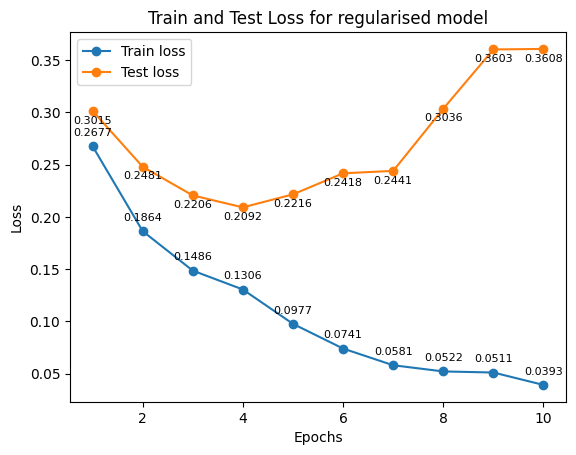

In [14]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.01}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.012})]
plotTitle = 'Train and Test Loss for regularised model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True)

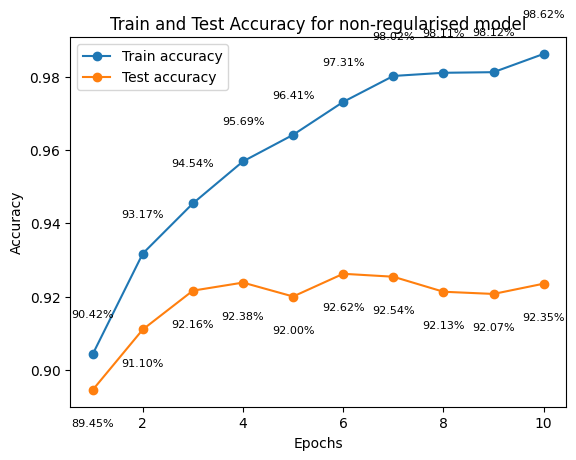

In [15]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': 0.01,
                                      'decimalPlaces': 2, 'displayPercent': True}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': -0.01,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for non-regularised model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True)

### Task 4.2: With regularisation and data augmentation applied <font color='green'>(3 points)</font>
Train and test the same model with different regularisation techniques applied where you apply them one at a time

In [16]:
# Apply only data augmentation for the training set
train_loader, test_loader = load_fashionMNIST_data(batch_size=64, augmentation=True)

# Instantiate the model (using regularisation if desired) and move it to the device (e.g. 'cuda' or 'cpu')
model = NetFashion(useRegularization=True).to(device)

epochs = 10  # Increasing the number of epochs for more gradual learning

# Define the optimiser (using Adam with a learning rate of 0.001)
optimiser = optim.Adam(model.parameters(), lr=0.001)

# Run the training loop which returns training and testing losses and accuracies
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model, loss_fn, optimiser, epochs)


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:

loss: 2.310718  [   64/60000]
loss: 0.911780  [ 6464/60000]
loss: 0.826755  [12864/60000]
loss: 0.516865  [19264/60000]
loss: 0.397765  [25664/60000]
loss: 0.277334  [32064/60000]
loss: 0.392747  [38464/60000]
loss: 0.420038  [44864/60000]
loss: 0.438481  [51264/60000]
loss: 0.407224  [57664/60000]


Epochs:  10%|█         | 1/10 [00:46<06:57, 46.43s/it]

Train Error: 
 Accuracy: 86.8%, Avg loss: 0.357061 

Test Error: 
 Accuracy: 86.6%, Avg loss: 0.361623 

Epoch 2:

loss: 0.319863  [   64/60000]
loss: 0.348253  [ 6464/60000]
loss: 0.546669  [12864/60000]
loss: 0.364387  [19264/60000]
loss: 0.707587  [25664/60000]
loss: 0.371255  [32064/60000]
loss: 0.214275  [38464/60000]
loss: 0.451371  [44864/60000]
loss: 0.285985  [51264/60000]
loss: 0.408636  [57664/60000]


Epochs:  20%|██        | 2/10 [01:32<06:09, 46.19s/it]

Train Error: 
 Accuracy: 89.6%, Avg loss: 0.279658 

Test Error: 
 Accuracy: 88.9%, Avg loss: 0.298444 

Epoch 3:

loss: 0.373011  [   64/60000]
loss: 0.262231  [ 6464/60000]
loss: 0.351045  [12864/60000]
loss: 0.261420  [19264/60000]
loss: 0.205586  [25664/60000]
loss: 0.428823  [32064/60000]
loss: 0.293488  [38464/60000]
loss: 0.272219  [44864/60000]
loss: 0.292420  [51264/60000]
loss: 0.142681  [57664/60000]


Epochs:  30%|███       | 3/10 [02:17<05:19, 45.70s/it]

Train Error: 
 Accuracy: 90.3%, Avg loss: 0.257899 

Test Error: 
 Accuracy: 89.5%, Avg loss: 0.275623 

Epoch 4:

loss: 0.337385  [   64/60000]
loss: 0.268976  [ 6464/60000]
loss: 0.301612  [12864/60000]
loss: 0.193605  [19264/60000]
loss: 0.290683  [25664/60000]
loss: 0.360840  [32064/60000]
loss: 0.373689  [38464/60000]
loss: 0.195393  [44864/60000]
loss: 0.229896  [51264/60000]
loss: 0.291740  [57664/60000]


Epochs:  40%|████      | 4/10 [03:02<04:32, 45.46s/it]

Train Error: 
 Accuracy: 91.5%, Avg loss: 0.226061 

Test Error: 
 Accuracy: 90.5%, Avg loss: 0.255222 

Epoch 5:

loss: 0.238833  [   64/60000]
loss: 0.319509  [ 6464/60000]
loss: 0.505949  [12864/60000]
loss: 0.195387  [19264/60000]
loss: 0.099131  [25664/60000]
loss: 0.287530  [32064/60000]
loss: 0.307774  [38464/60000]
loss: 0.136729  [44864/60000]
loss: 0.242395  [51264/60000]
loss: 0.260153  [57664/60000]


Epochs:  50%|█████     | 5/10 [03:47<03:46, 45.36s/it]

Train Error: 
 Accuracy: 91.9%, Avg loss: 0.216662 

Test Error: 
 Accuracy: 90.9%, Avg loss: 0.253189 

Epoch 6:

loss: 0.235846  [   64/60000]
loss: 0.296984  [ 6464/60000]
loss: 0.298210  [12864/60000]
loss: 0.271238  [19264/60000]
loss: 0.364811  [25664/60000]
loss: 0.238168  [32064/60000]
loss: 0.291849  [38464/60000]
loss: 0.204296  [44864/60000]
loss: 0.085154  [51264/60000]
loss: 0.445747  [57664/60000]


Epochs:  60%|██████    | 6/10 [04:33<03:01, 45.33s/it]

Train Error: 
 Accuracy: 92.5%, Avg loss: 0.200995 

Test Error: 
 Accuracy: 91.5%, Avg loss: 0.227986 

Epoch 7:

loss: 0.288147  [   64/60000]
loss: 0.364663  [ 6464/60000]
loss: 0.262745  [12864/60000]
loss: 0.355595  [19264/60000]
loss: 0.291142  [25664/60000]
loss: 0.444291  [32064/60000]
loss: 0.192085  [38464/60000]
loss: 0.173088  [44864/60000]
loss: 0.133113  [51264/60000]
loss: 0.286166  [57664/60000]


Epochs:  70%|███████   | 7/10 [05:18<02:15, 45.29s/it]

Train Error: 
 Accuracy: 92.8%, Avg loss: 0.194486 

Test Error: 
 Accuracy: 91.8%, Avg loss: 0.231507 

Epoch 8:

loss: 0.207074  [   64/60000]
loss: 0.256186  [ 6464/60000]
loss: 0.350833  [12864/60000]
loss: 0.128059  [19264/60000]
loss: 0.122559  [25664/60000]
loss: 0.266867  [32064/60000]
loss: 0.276825  [38464/60000]
loss: 0.206489  [44864/60000]
loss: 0.300503  [51264/60000]
loss: 0.244250  [57664/60000]


Epochs:  80%|████████  | 8/10 [06:03<01:30, 45.38s/it]

Train Error: 
 Accuracy: 93.1%, Avg loss: 0.185679 

Test Error: 
 Accuracy: 92.1%, Avg loss: 0.224133 

Epoch 9:

loss: 0.179650  [   64/60000]
loss: 0.095081  [ 6464/60000]
loss: 0.200354  [12864/60000]
loss: 0.135851  [19264/60000]
loss: 0.215901  [25664/60000]
loss: 0.371704  [32064/60000]
loss: 0.183261  [38464/60000]
loss: 0.231386  [44864/60000]
loss: 0.101384  [51264/60000]
loss: 0.128754  [57664/60000]


Epochs:  90%|█████████ | 9/10 [06:50<00:45, 45.76s/it]

Train Error: 
 Accuracy: 93.6%, Avg loss: 0.172245 

Test Error: 
 Accuracy: 92.5%, Avg loss: 0.214379 

Epoch 10:

loss: 0.188454  [   64/60000]
loss: 0.380656  [ 6464/60000]
loss: 0.219355  [12864/60000]
loss: 0.255186  [19264/60000]
loss: 0.337684  [25664/60000]
loss: 0.241423  [32064/60000]
loss: 0.238458  [38464/60000]
loss: 0.308838  [44864/60000]
loss: 0.287214  [51264/60000]
loss: 0.140680  [57664/60000]


Epochs: 100%|██████████| 10/10 [07:37<00:00, 45.70s/it]

Train Error: 
 Accuracy: 93.5%, Avg loss: 0.173362 

Test Error: 
 Accuracy: 92.4%, Avg loss: 0.215872 

Done training!


Plotting metrics

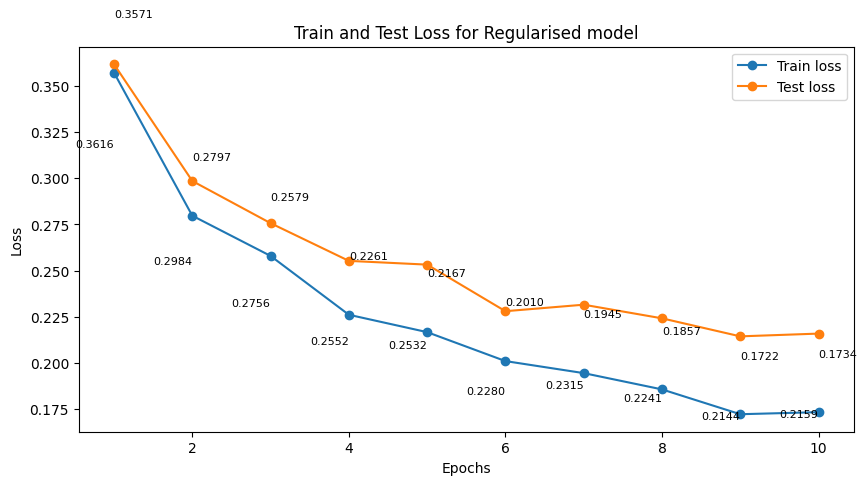

In [17]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.03, 'ha': 'left'}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.045, 'ha': 'right'})]
plotTitle = 'Train and Test Loss for Regularised model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True, figSize=(10, 5))

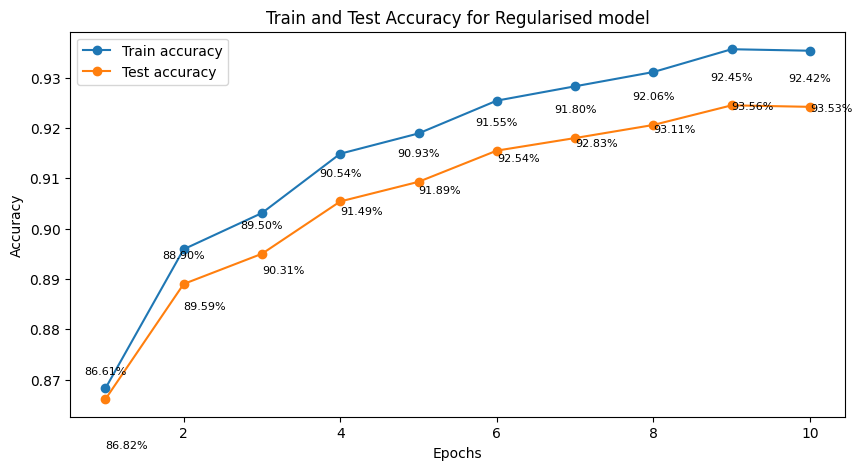

In [18]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': -0.012,
                                      'decimalPlaces': 2, 'displayPercent': True, 'ha': 'left'}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': 0.005,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for Regularised model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True, figSize=(10, 5))

In [19]:
# Apply only regularisation on the CNN model (no data augmentation)
train_loader, test_loader = load_fashionMNIST_data(batch_size=64, augmentation=False)

# Instantiate the model with regularisation (dropout enabled) and move it to the device
model = NetFashion(useRegularization=True).to(device)

epochs = 10  # Increasing the number of epochs for more gradual learning

# Define the optimiser (using Adam with a learning rate of 0.001)
optimiser = optim.Adam(model.parameters(), lr=0.001)

# Run the training loop which returns the losses and accuracies for both training and test sets
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model, loss_fn, optimiser, epochs)


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:

loss: 2.319070  [   64/60000]
loss: 0.512433  [ 6464/60000]
loss: 0.414112  [12864/60000]
loss: 0.608635  [19264/60000]
loss: 0.300317  [25664/60000]
loss: 0.267870  [32064/60000]
loss: 0.438438  [38464/60000]
loss: 0.362429  [44864/60000]
loss: 0.269548  [51264/60000]
loss: 0.227854  [57664/60000]


Epochs:  10%|█         | 1/10 [00:30<04:37, 30.86s/it]

Train Error: 
 Accuracy: 90.0%, Avg loss: 0.265822 

Test Error: 
 Accuracy: 88.8%, Avg loss: 0.300123 

Epoch 2:

loss: 0.413741  [   64/60000]
loss: 0.422629  [ 6464/60000]
loss: 0.258042  [12864/60000]
loss: 0.290753  [19264/60000]
loss: 0.213379  [25664/60000]
loss: 0.208820  [32064/60000]
loss: 0.262760  [38464/60000]
loss: 0.278238  [44864/60000]
loss: 0.329259  [51264/60000]
loss: 0.417304  [57664/60000]


Epochs:  20%|██        | 2/10 [01:01<04:07, 30.89s/it]

Train Error: 
 Accuracy: 91.9%, Avg loss: 0.209172 

Test Error: 
 Accuracy: 90.5%, Avg loss: 0.255740 

Epoch 3:

loss: 0.357995  [   64/60000]
loss: 0.399211  [ 6464/60000]
loss: 0.148889  [12864/60000]
loss: 0.206176  [19264/60000]
loss: 0.132616  [25664/60000]
loss: 0.335690  [32064/60000]
loss: 0.214491  [38464/60000]
loss: 0.243182  [44864/60000]
loss: 0.277292  [51264/60000]
loss: 0.197145  [57664/60000]


Epochs:  30%|███       | 3/10 [01:33<03:39, 31.39s/it]

Train Error: 
 Accuracy: 93.9%, Avg loss: 0.165869 

Test Error: 
 Accuracy: 91.7%, Avg loss: 0.222081 

Epoch 4:

loss: 0.138112  [   64/60000]
loss: 0.117969  [ 6464/60000]
loss: 0.180197  [12864/60000]
loss: 0.175511  [19264/60000]
loss: 0.088187  [25664/60000]
loss: 0.292370  [32064/60000]
loss: 0.166989  [38464/60000]
loss: 0.094576  [44864/60000]
loss: 0.392616  [51264/60000]
loss: 0.258041  [57664/60000]


Epochs:  40%|████      | 4/10 [02:09<03:17, 32.92s/it]

Train Error: 
 Accuracy: 94.3%, Avg loss: 0.153998 

Test Error: 
 Accuracy: 91.7%, Avg loss: 0.220869 

Epoch 5:

loss: 0.122587  [   64/60000]
loss: 0.196217  [ 6464/60000]
loss: 0.257083  [12864/60000]
loss: 0.278016  [19264/60000]
loss: 0.242986  [25664/60000]
loss: 0.159602  [32064/60000]
loss: 0.192061  [38464/60000]
loss: 0.252712  [44864/60000]
loss: 0.123064  [51264/60000]
loss: 0.106245  [57664/60000]


Epochs:  50%|█████     | 5/10 [02:44<02:49, 33.90s/it]

Train Error: 
 Accuracy: 95.3%, Avg loss: 0.130034 

Test Error: 
 Accuracy: 92.0%, Avg loss: 0.214631 

Epoch 6:

loss: 0.129044  [   64/60000]
loss: 0.183022  [ 6464/60000]
loss: 0.133550  [12864/60000]
loss: 0.115789  [19264/60000]
loss: 0.162228  [25664/60000]
loss: 0.199174  [32064/60000]
loss: 0.176607  [38464/60000]
loss: 0.149483  [44864/60000]
loss: 0.182751  [51264/60000]
loss: 0.257513  [57664/60000]


Epochs:  60%|██████    | 6/10 [03:19<02:16, 34.25s/it]

Train Error: 
 Accuracy: 95.9%, Avg loss: 0.114241 

Test Error: 
 Accuracy: 92.6%, Avg loss: 0.207493 

Epoch 7:

loss: 0.118469  [   64/60000]
loss: 0.120926  [ 6464/60000]
loss: 0.157166  [12864/60000]
loss: 0.204653  [19264/60000]
loss: 0.103858  [25664/60000]
loss: 0.157248  [32064/60000]
loss: 0.148189  [38464/60000]
loss: 0.279135  [44864/60000]
loss: 0.225961  [51264/60000]
loss: 0.213252  [57664/60000]


Epochs:  70%|███████   | 7/10 [03:54<01:43, 34.56s/it]

Train Error: 
 Accuracy: 96.1%, Avg loss: 0.102336 

Test Error: 
 Accuracy: 92.4%, Avg loss: 0.221909 

Epoch 8:

loss: 0.099970  [   64/60000]
loss: 0.170132  [ 6464/60000]
loss: 0.160026  [12864/60000]
loss: 0.165106  [19264/60000]
loss: 0.252385  [25664/60000]
loss: 0.234770  [32064/60000]
loss: 0.201782  [38464/60000]
loss: 0.080981  [44864/60000]
loss: 0.141662  [51264/60000]
loss: 0.173721  [57664/60000]


Epochs:  80%|████████  | 8/10 [04:29<01:09, 34.64s/it]

Train Error: 
 Accuracy: 96.8%, Avg loss: 0.091384 

Test Error: 
 Accuracy: 92.7%, Avg loss: 0.215291 

Epoch 9:

loss: 0.151325  [   64/60000]
loss: 0.063758  [ 6464/60000]
loss: 0.073666  [12864/60000]
loss: 0.199662  [19264/60000]
loss: 0.063693  [25664/60000]
loss: 0.073143  [32064/60000]
loss: 0.112190  [38464/60000]
loss: 0.073302  [44864/60000]
loss: 0.072784  [51264/60000]
loss: 0.087530  [57664/60000]


Epochs:  90%|█████████ | 9/10 [05:04<00:34, 34.66s/it]

Train Error: 
 Accuracy: 97.1%, Avg loss: 0.077828 

Test Error: 
 Accuracy: 92.8%, Avg loss: 0.220873 

Epoch 10:

loss: 0.121046  [   64/60000]
loss: 0.133622  [ 6464/60000]
loss: 0.169566  [12864/60000]
loss: 0.099597  [19264/60000]
loss: 0.085206  [25664/60000]
loss: 0.163219  [32064/60000]
loss: 0.090459  [38464/60000]
loss: 0.057552  [44864/60000]
loss: 0.059005  [51264/60000]
loss: 0.120221  [57664/60000]


Epochs: 100%|██████████| 10/10 [05:36<00:00, 33.65s/it]

Train Error: 
 Accuracy: 97.2%, Avg loss: 0.075260 

Test Error: 
 Accuracy: 92.6%, Avg loss: 0.237100 

Done training!


Plotting metrics

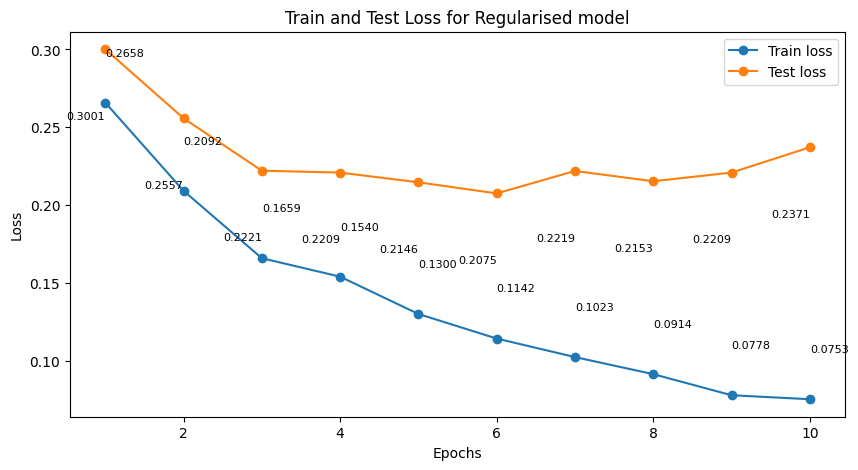

In [20]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.03, 'ha': 'left'}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.045, 'ha': 'right'})]
plotTitle = 'Train and Test Loss for Regularised model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True, figSize=(10, 5))

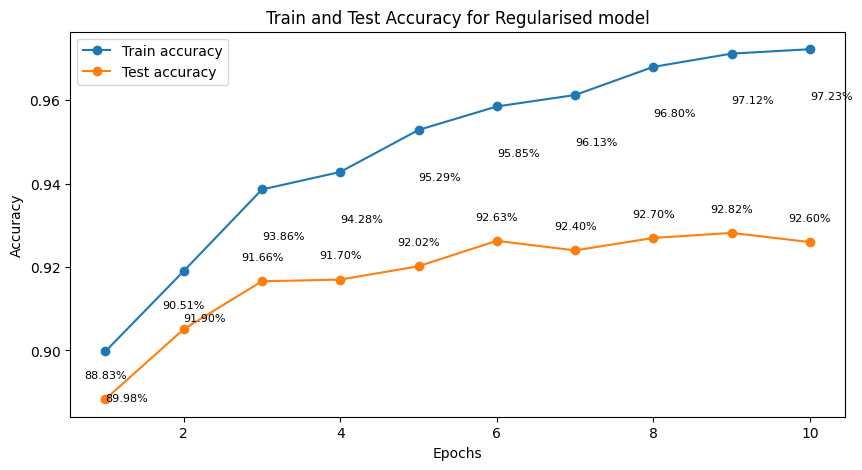

In [21]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': -0.012,
                                      'decimalPlaces': 2, 'displayPercent': True, 'ha': 'left'}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': 0.005,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for Regularised model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True, figSize=(10, 5))

In [22]:
# Apply only weight decay technique (L2 regularisation)
train_loader, test_loader = load_fashionMNIST_data(batch_size=64, augmentation=False)

# Instantiate the model without extra dropout regularisation
model = NetFashion(useRegularization=False).to(device)

epochs = 10  # Using 10 epochs for gradual learning

# Define the optimiser (Adam with weight_decay for L2 regularisation)
optimiser = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Execute the training loop
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model, loss_fn, optimiser, epochs)


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:

loss: 2.307465  [   64/60000]
loss: 0.409217  [ 6464/60000]
loss: 0.383499  [12864/60000]
loss: 0.446865  [19264/60000]
loss: 0.210406  [25664/60000]
loss: 0.575322  [32064/60000]
loss: 0.402150  [38464/60000]
loss: 0.260080  [44864/60000]
loss: 0.264512  [51264/60000]
loss: 0.165343  [57664/60000]


Epochs:  10%|█         | 1/10 [00:32<04:48, 32.10s/it]

Train Error: 
 Accuracy: 90.5%, Avg loss: 0.257130 

Test Error: 
 Accuracy: 89.2%, Avg loss: 0.292226 

Epoch 2:

loss: 0.281360  [   64/60000]
loss: 0.317027  [ 6464/60000]
loss: 0.145496  [12864/60000]
loss: 0.249368  [19264/60000]
loss: 0.225299  [25664/60000]
loss: 0.263118  [32064/60000]
loss: 0.220610  [38464/60000]
loss: 0.273382  [44864/60000]
loss: 0.199847  [51264/60000]
loss: 0.247917  [57664/60000]


Epochs:  20%|██        | 2/10 [01:04<04:18, 32.34s/it]

Train Error: 
 Accuracy: 92.9%, Avg loss: 0.191674 

Test Error: 
 Accuracy: 91.1%, Avg loss: 0.248158 

Epoch 3:

loss: 0.123549  [   64/60000]
loss: 0.131951  [ 6464/60000]
loss: 0.116944  [12864/60000]
loss: 0.099575  [19264/60000]
loss: 0.118540  [25664/60000]
loss: 0.254404  [32064/60000]
loss: 0.179342  [38464/60000]
loss: 0.198133  [44864/60000]
loss: 0.280043  [51264/60000]
loss: 0.156008  [57664/60000]


Epochs:  30%|███       | 3/10 [01:37<03:47, 32.47s/it]

Train Error: 
 Accuracy: 93.7%, Avg loss: 0.165549 

Test Error: 
 Accuracy: 91.7%, Avg loss: 0.224691 

Epoch 4:

loss: 0.096177  [   64/60000]
loss: 0.246120  [ 6464/60000]
loss: 0.176831  [12864/60000]
loss: 0.095834  [19264/60000]
loss: 0.207249  [25664/60000]
loss: 0.045301  [32064/60000]
loss: 0.083140  [38464/60000]
loss: 0.298981  [44864/60000]
loss: 0.141122  [51264/60000]
loss: 0.143115  [57664/60000]


Epochs:  40%|████      | 4/10 [02:09<03:13, 32.26s/it]

Train Error: 
 Accuracy: 95.0%, Avg loss: 0.134105 

Test Error: 
 Accuracy: 92.3%, Avg loss: 0.218991 

Epoch 5:

loss: 0.092682  [   64/60000]
loss: 0.083399  [ 6464/60000]
loss: 0.197096  [12864/60000]
loss: 0.164682  [19264/60000]
loss: 0.060439  [25664/60000]
loss: 0.202188  [32064/60000]
loss: 0.094784  [38464/60000]
loss: 0.229008  [44864/60000]
loss: 0.034165  [51264/60000]
loss: 0.226349  [57664/60000]


Epochs:  50%|█████     | 5/10 [02:41<02:42, 32.41s/it]

Train Error: 
 Accuracy: 95.3%, Avg loss: 0.126873 

Test Error: 
 Accuracy: 91.9%, Avg loss: 0.229407 

Epoch 6:

loss: 0.091596  [   64/60000]
loss: 0.145457  [ 6464/60000]
loss: 0.200403  [12864/60000]
loss: 0.101031  [19264/60000]
loss: 0.066369  [25664/60000]
loss: 0.170241  [32064/60000]
loss: 0.112159  [38464/60000]
loss: 0.165276  [44864/60000]
loss: 0.108037  [51264/60000]
loss: 0.125289  [57664/60000]


Epochs:  60%|██████    | 6/10 [03:13<02:09, 32.27s/it]

Train Error: 
 Accuracy: 96.8%, Avg loss: 0.088928 

Test Error: 
 Accuracy: 92.7%, Avg loss: 0.218686 

Epoch 7:

loss: 0.071695  [   64/60000]
loss: 0.060241  [ 6464/60000]
loss: 0.055738  [12864/60000]
loss: 0.084035  [19264/60000]
loss: 0.066006  [25664/60000]
loss: 0.096772  [32064/60000]
loss: 0.196484  [38464/60000]
loss: 0.105384  [44864/60000]
loss: 0.121605  [51264/60000]
loss: 0.046547  [57664/60000]


Epochs:  70%|███████   | 7/10 [03:44<01:35, 31.89s/it]

Train Error: 
 Accuracy: 97.2%, Avg loss: 0.076258 

Test Error: 
 Accuracy: 92.6%, Avg loss: 0.231402 

Epoch 8:

loss: 0.088819  [   64/60000]
loss: 0.056755  [ 6464/60000]
loss: 0.104078  [12864/60000]
loss: 0.054858  [19264/60000]
loss: 0.156784  [25664/60000]
loss: 0.090218  [32064/60000]
loss: 0.036580  [38464/60000]
loss: 0.063461  [44864/60000]
loss: 0.146003  [51264/60000]
loss: 0.108349  [57664/60000]


Epochs:  80%|████████  | 8/10 [04:16<01:03, 31.79s/it]

Train Error: 
 Accuracy: 97.5%, Avg loss: 0.069285 

Test Error: 
 Accuracy: 92.3%, Avg loss: 0.241629 

Epoch 9:

loss: 0.063269  [   64/60000]
loss: 0.077897  [ 6464/60000]
loss: 0.068026  [12864/60000]
loss: 0.053675  [19264/60000]
loss: 0.023953  [25664/60000]
loss: 0.047385  [32064/60000]
loss: 0.140871  [38464/60000]
loss: 0.170072  [44864/60000]
loss: 0.225366  [51264/60000]
loss: 0.074590  [57664/60000]


Epochs:  90%|█████████ | 9/10 [04:47<00:31, 31.63s/it]

Train Error: 
 Accuracy: 97.7%, Avg loss: 0.064266 

Test Error: 
 Accuracy: 92.2%, Avg loss: 0.251347 

Epoch 10:

loss: 0.040290  [   64/60000]
loss: 0.013791  [ 6464/60000]
loss: 0.120597  [12864/60000]
loss: 0.080590  [19264/60000]
loss: 0.040040  [25664/60000]
loss: 0.061662  [32064/60000]
loss: 0.064562  [38464/60000]
loss: 0.132753  [44864/60000]
loss: 0.050951  [51264/60000]
loss: 0.068026  [57664/60000]


Epochs: 100%|██████████| 10/10 [05:19<00:00, 31.93s/it]

Train Error: 
 Accuracy: 98.2%, Avg loss: 0.051166 

Test Error: 
 Accuracy: 92.5%, Avg loss: 0.288089 

Done training!


Plotting metrics

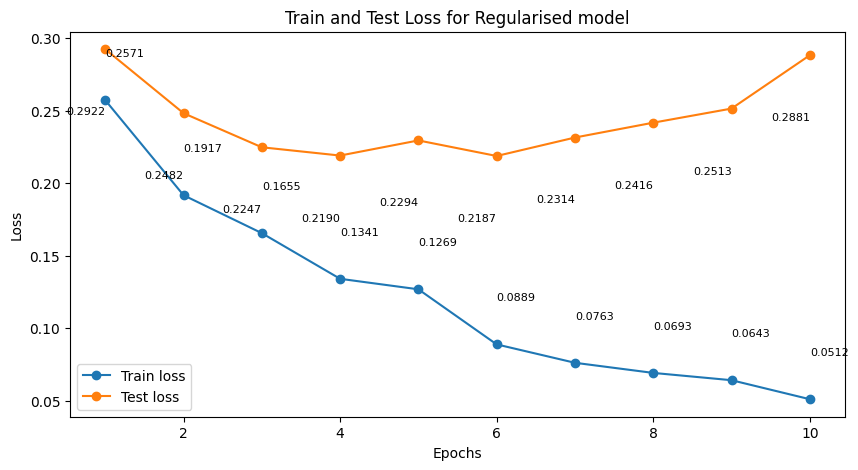

In [23]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.03, 'ha': 'left'}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.045, 'ha': 'right'})]
plotTitle = 'Train and Test Loss for Regularised model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True, figSize=(10, 5))

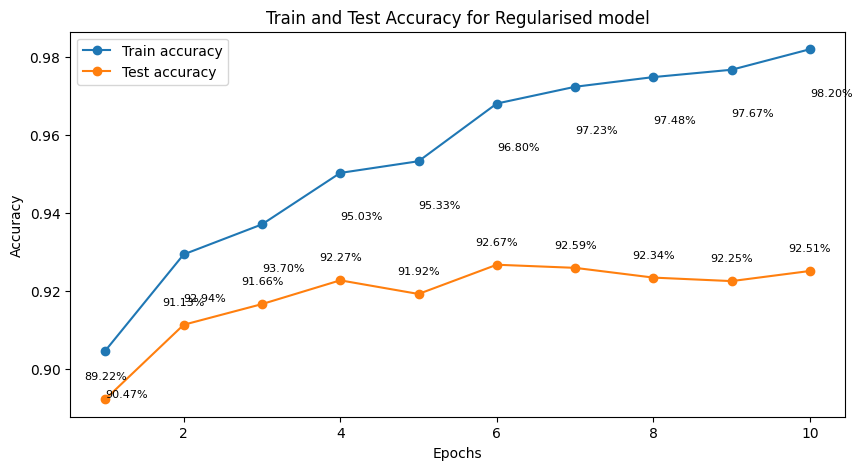

In [24]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': -0.012,
                                      'decimalPlaces': 2, 'displayPercent': True, 'ha': 'left'}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': 0.005,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for Regularised model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True, figSize=(10, 5))

Apply all the regularisation techniques together below

In [25]:
# Apply all regularisation techniques: data augmentation, dropout, and weight decay.
train_loader, test_loader = load_fashionMNIST_data(batch_size=64, augmentation=True)

# Instantiate the model with dropout enabled (useRegularization=True) and move it to the device.
model = NetFashion(useRegularization=True).to(device)

epochs = 10  # Increasing the number of epochs for more gradual learning.

# Define the optimiser using Adam with weight decay (L2 regularisation)
optimiser = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Execute the training loop which returns training and testing losses and accuracies.
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model, loss_fn, optimiser, epochs)


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:

loss: 2.301169  [   64/60000]
loss: 0.475272  [ 6464/60000]
loss: 0.712586  [12864/60000]
loss: 0.422988  [19264/60000]
loss: 0.608999  [25664/60000]
loss: 0.419442  [32064/60000]
loss: 0.390850  [38464/60000]
loss: 0.462527  [44864/60000]
loss: 0.244131  [51264/60000]
loss: 0.375677  [57664/60000]


Epochs:  10%|█         | 1/10 [00:47<07:07, 47.54s/it]

Train Error: 
 Accuracy: 87.2%, Avg loss: 0.344431 

Test Error: 
 Accuracy: 86.4%, Avg loss: 0.349094 

Epoch 2:

loss: 0.315034  [   64/60000]
loss: 0.310569  [ 6464/60000]
loss: 0.384450  [12864/60000]
loss: 0.494067  [19264/60000]
loss: 0.365737  [25664/60000]
loss: 0.338828  [32064/60000]
loss: 0.379730  [38464/60000]
loss: 0.249712  [44864/60000]
loss: 0.229391  [51264/60000]
loss: 0.308616  [57664/60000]


Epochs:  20%|██        | 2/10 [01:34<06:18, 47.26s/it]

Train Error: 
 Accuracy: 90.1%, Avg loss: 0.267889 

Test Error: 
 Accuracy: 89.6%, Avg loss: 0.276903 

Epoch 3:

loss: 0.384423  [   64/60000]
loss: 0.278681  [ 6464/60000]
loss: 0.376566  [12864/60000]
loss: 0.413152  [19264/60000]
loss: 0.395521  [25664/60000]
loss: 0.368519  [32064/60000]
loss: 0.321444  [38464/60000]
loss: 0.231799  [44864/60000]
loss: 0.199093  [51264/60000]
loss: 0.518307  [57664/60000]


Epochs:  30%|███       | 3/10 [02:22<05:31, 47.40s/it]

Train Error: 
 Accuracy: 90.5%, Avg loss: 0.251008 

Test Error: 
 Accuracy: 89.9%, Avg loss: 0.266772 

Epoch 4:

loss: 0.314349  [   64/60000]
loss: 0.401684  [ 6464/60000]
loss: 0.414115  [12864/60000]
loss: 0.334871  [19264/60000]
loss: 0.199205  [25664/60000]
loss: 0.332694  [32064/60000]
loss: 0.434509  [38464/60000]
loss: 0.192474  [44864/60000]
loss: 0.229986  [51264/60000]
loss: 0.150280  [57664/60000]


Epochs:  40%|████      | 4/10 [03:09<04:44, 47.36s/it]

Train Error: 
 Accuracy: 91.8%, Avg loss: 0.221360 

Test Error: 
 Accuracy: 90.9%, Avg loss: 0.252045 

Epoch 5:

loss: 0.272735  [   64/60000]
loss: 0.237564  [ 6464/60000]
loss: 0.267565  [12864/60000]
loss: 0.263468  [19264/60000]
loss: 0.205097  [25664/60000]
loss: 0.268932  [32064/60000]
loss: 0.289619  [38464/60000]
loss: 0.209649  [44864/60000]
loss: 0.265638  [51264/60000]
loss: 0.475544  [57664/60000]


Epochs:  50%|█████     | 5/10 [03:56<03:57, 47.41s/it]

Train Error: 
 Accuracy: 92.5%, Avg loss: 0.204263 

Test Error: 
 Accuracy: 91.5%, Avg loss: 0.232395 

Epoch 6:

loss: 0.212148  [   64/60000]
loss: 0.213256  [ 6464/60000]
loss: 0.321870  [12864/60000]
loss: 0.186956  [19264/60000]
loss: 0.110723  [25664/60000]
loss: 0.128315  [32064/60000]
loss: 0.238905  [38464/60000]
loss: 0.251728  [44864/60000]
loss: 0.127248  [51264/60000]
loss: 0.192556  [57664/60000]


Epochs:  60%|██████    | 6/10 [04:45<03:10, 47.69s/it]

Train Error: 
 Accuracy: 92.5%, Avg loss: 0.203321 

Test Error: 
 Accuracy: 91.9%, Avg loss: 0.225128 

Epoch 7:

loss: 0.180076  [   64/60000]
loss: 0.164489  [ 6464/60000]
loss: 0.370061  [12864/60000]
loss: 0.219746  [19264/60000]
loss: 0.101241  [25664/60000]
loss: 0.267292  [32064/60000]
loss: 0.216614  [38464/60000]
loss: 0.312042  [44864/60000]
loss: 0.282938  [51264/60000]
loss: 0.132213  [57664/60000]


Epochs:  70%|███████   | 7/10 [05:33<02:23, 47.76s/it]

Train Error: 
 Accuracy: 91.7%, Avg loss: 0.214695 

Test Error: 
 Accuracy: 91.3%, Avg loss: 0.244808 

Epoch 8:

loss: 0.365685  [   64/60000]
loss: 0.322178  [ 6464/60000]
loss: 0.206013  [12864/60000]
loss: 0.233594  [19264/60000]
loss: 0.396522  [25664/60000]
loss: 0.222519  [32064/60000]
loss: 0.320585  [38464/60000]
loss: 0.216280  [44864/60000]
loss: 0.236864  [51264/60000]
loss: 0.222228  [57664/60000]


Epochs:  80%|████████  | 8/10 [06:21<01:35, 47.82s/it]

Train Error: 
 Accuracy: 93.1%, Avg loss: 0.185707 

Test Error: 
 Accuracy: 92.1%, Avg loss: 0.215835 

Epoch 9:

loss: 0.300079  [   64/60000]
loss: 0.145484  [ 6464/60000]
loss: 0.350343  [12864/60000]
loss: 0.200442  [19264/60000]
loss: 0.236050  [25664/60000]
loss: 0.153430  [32064/60000]
loss: 0.198361  [38464/60000]
loss: 0.415867  [44864/60000]
loss: 0.220502  [51264/60000]
loss: 0.164362  [57664/60000]


Epochs:  90%|█████████ | 9/10 [07:08<00:47, 47.81s/it]

Train Error: 
 Accuracy: 93.1%, Avg loss: 0.186301 

Test Error: 
 Accuracy: 92.1%, Avg loss: 0.223792 

Epoch 10:

loss: 0.100715  [   64/60000]
loss: 0.330321  [ 6464/60000]
loss: 0.292919  [12864/60000]
loss: 0.250355  [19264/60000]
loss: 0.125866  [25664/60000]
loss: 0.264733  [32064/60000]
loss: 0.135276  [38464/60000]
loss: 0.224909  [44864/60000]
loss: 0.148831  [51264/60000]
loss: 0.374157  [57664/60000]


Epochs: 100%|██████████| 10/10 [07:56<00:00, 47.62s/it]

Train Error: 
 Accuracy: 93.5%, Avg loss: 0.180393 

Test Error: 
 Accuracy: 92.2%, Avg loss: 0.218150 

Done training!


Plotting metrics

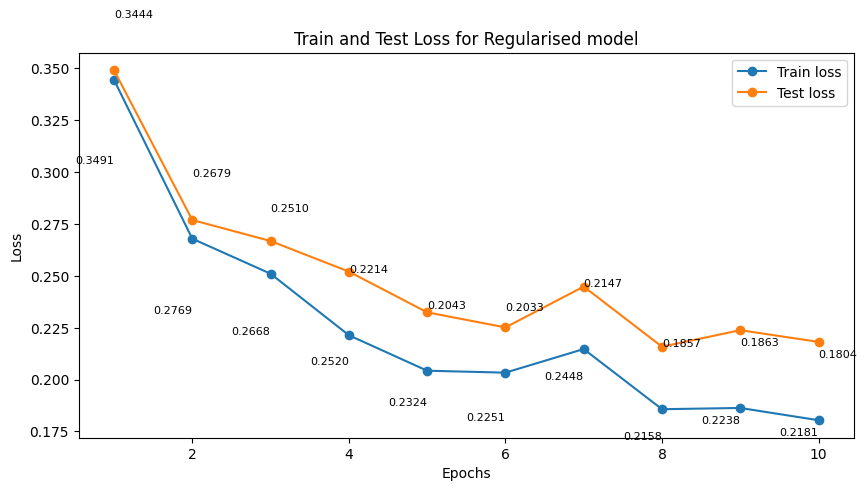

In [26]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.03, 'ha': 'left'}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.045, 'ha': 'right'})]
plotTitle = 'Train and Test Loss for Regularised model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True, figSize=(10, 5))

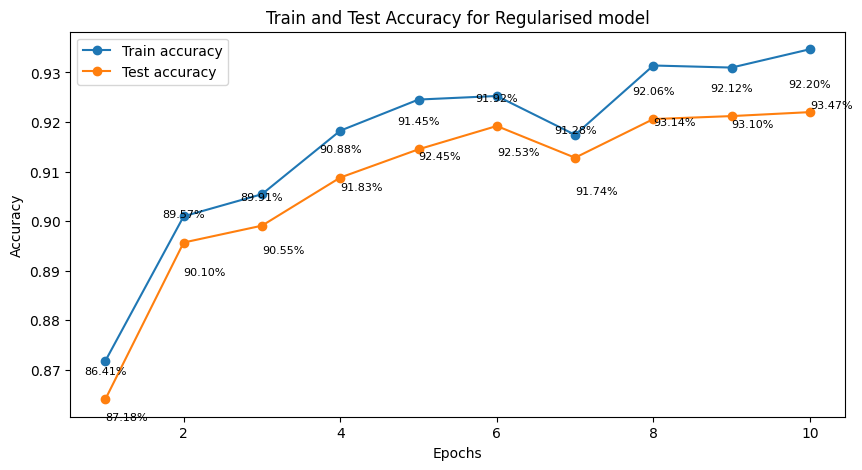

In [27]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': -0.012,
                                      'decimalPlaces': 2, 'displayPercent': True, 'ha': 'left'}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': 0.005,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for Regularised model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True, figSize=(10, 5))

## Reflection <font color='green'>(1 point)</font>
Write your thoughts and observations about overfitting and the techniques used above to reduce them in brief.

<font color='red'>Overfitting occurs when a model learns the training data too precisely, including its noise, which hurts its performance on unseen data. Data augmentation diversifies the training set, dropout prevents reliance on specific neurons, and weight decay penalises large weights—each technique helping the model generalise better.</font>

